<a href="https://colab.research.google.com/github/Natasha617/-advanced-machine-learning/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет.

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [2]:
import pandas as pd
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/magamed/introduction ML/SVC/persons_pics_train.csv' /content/data.csv

In [5]:
df = pd.read_csv('data.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [6]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

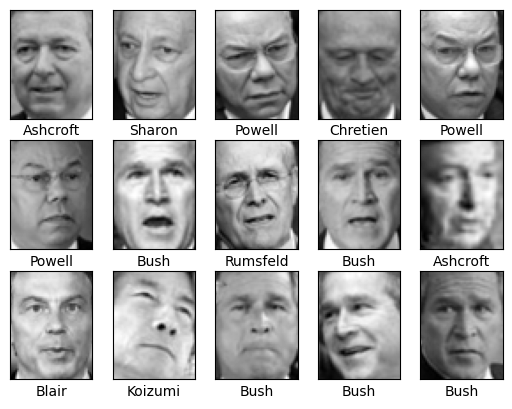

In [7]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Крупнее

(-0.5, 46.5, 61.5, -0.5)

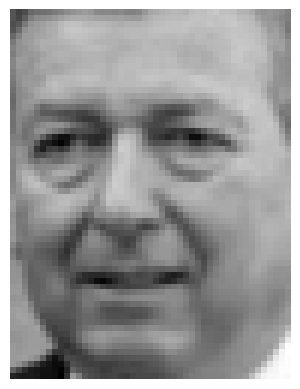

In [8]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [9]:
df['label'].value_counts()

George W Bush        451
Colin Powell         201
Tony Blair           122
Donald Rumsfeld      103
Gerhard Schroeder     93
Ariel Sharon          65
Hugo Chavez           60
Junichiro Koizumi     51
Jean Chretien         47
John Ashcroft         45
Serena Williams       44
Jacques Chirac        44
Name: label, dtype: int64

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса.

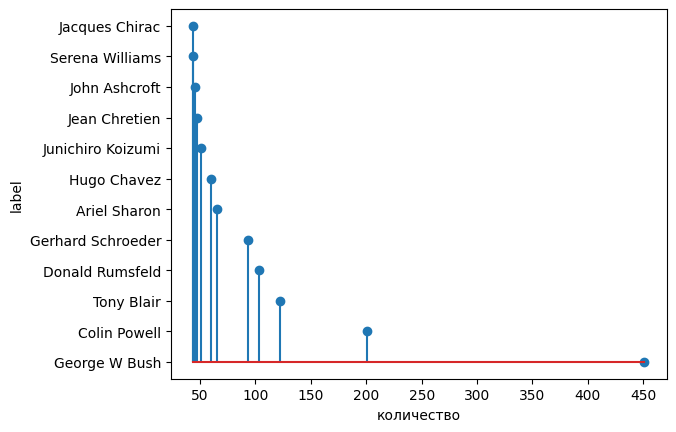

In [10]:
x_value = df['label'].value_counts()

plt.stem(x_value.values, x_value.index)
plt.ylabel('label')
plt.xlabel('количество')
plt.show()

In [ ]:
44/df['label'].value_counts().sum()

0.033182503770739065

In [12]:
df[df['label']=='Gerhard Schroeder'].mean()

<ipython-input-12-a0827217f5b7>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[df['label']=='Gerhard Schroeder'].mean()


0       0.210162
1       0.228210
2       0.268255
3       0.328344
4       0.389332
          ...   
2909    0.482550
2910    0.442252
2911    0.428477
2912    0.426875
2913    0.411118
Length: 2914, dtype: float64

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

<ipython-input-15-8b2bce64fea5>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.imshow(natasha(df[df['label']=='Junichiro Koizumi'].mean()),cmap='gray' )


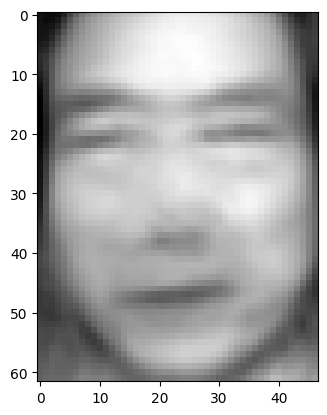

In [15]:
def natasha(row):
  return row.to_numpy().reshape(62,47)
plt.imshow(natasha(df[df['label']=='Junichiro Koizumi'].mean()),cmap='gray' )

Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [ ]:
# < ENTER YOUR CODE HERE >

Используя усредненные векторы, постройте изображения всех людей из набора данных.

In [ ]:
# < ENTER YOUR CODE HERE >

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

Введите значение косинусного сходства между парой усредненных векторов Donald Rumsfeld и Serena Williams.

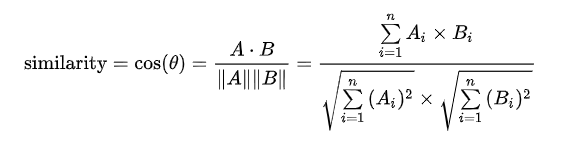

In [16]:
meam_serena = df[df['label']=='Serena Williams'].mean()
meam_donald = df[df['label']=='Donald Rumsfeld'].mean()

<ipython-input-16-d4c0dce5c9c7>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meam_serena = df[df['label']=='Serena Williams'].mean()
<ipython-input-16-d4c0dce5c9c7>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meam_donald = df[df['label']=='Donald Rumsfeld'].mean()


Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [18]:
import numpy as np

In [ ]:
np.linalg.norm()

In [20]:
np.dot(meam_serena, meam_donald)/(np.linalg.norm(meam_serena) * np.linalg.norm(meam_donald))

0.9866056618941133

In [17]:
meam_serena

0       0.412983
1       0.390434
2       0.359091
3       0.333541
4       0.337136
          ...   
2909    0.308200
2910    0.322460
2911    0.334492
2912    0.348247
2913    0.361854
Length: 2914, dtype: float64

In [ ]:
# < ENTER YOUR CODE HERE >

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [23]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(columns = 'label'), df['label'], random_state=5, test_size=0.2, stratify=df['label'])

In [27]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', random_state=5).fit(x_train, y_train)
round(f1_score(y_test, svc.predict(x_test), average='weighted'),3)


0.741

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[5]}]


svc = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
svc.fit(x_train, y_train)
best_p = svc.best_params_
best_p

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.778 total time=   3.8s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   3.4s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.825 total time=   2.2s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.802 total time=   1.7s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.769 total time=   1.6s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.377 total time=   1.6s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.358 total time=   1.7s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.373 total time=   1.7s
[CV 4/5] END C=1, class_weight=None, gam

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'sigmoid',
 'random_state': 5}

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [ ]:
# < ENTER YOUR CODE HERE >

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
# < ENTER YOUR CODE HERE >

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [ ]:
# < ENTER YOUR CODE HERE >

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE >

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [30]:

round(f1_score(y_test, svc.best_estimator_.predict(x_test), average='weighted'),3)


0.771

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [31]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(svd_solver='full', n_components=0.95)
pca.fit(x_train)


PCA(n_components=0.95, svd_solver='full')

In [37]:
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [38]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[5]}]


svc = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
svc.fit(x_train_pca, y_train)
best_p = svc.best_params_
best_p

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.750 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.811 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.344 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gam

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'rbf',
 'random_state': 5}

In [ ]:
# < ENTER YOUR CODE HERE >

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE >

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [39]:
round(f1_score(y_test, svc.best_estimator_.predict(x_test_pca),average='weighted'),3)

0.755

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.

# Часть 2

In [52]:
best_p['kernel']='sigmoid'
best_p.pop('random_state')

5

In [53]:
best_p

{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'sigmoid'}

In [43]:
!cp '/content/drive/MyDrive/magamed/introduction ML/SVC/persons_pics_reserved.csv' /content/data_test.csv

In [45]:
data_test = pd.read_csv('data_test.csv')

In [54]:
svc5 = SVC(**best_p).fit(df.drop(columns = 'label'),df['label'])

In [ ]:
svc5.predict(data_test)

In [56]:
df

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,0.237908,0.273203,0.244444,0.332026,0.590850,0.675817,0.684967,0.733333,0.771242,0.771242,...,0.686275,0.694118,0.720261,0.746405,0.756863,0.735948,0.715033,0.684967,0.657516,Tony Blair
1322,0.105882,0.087582,0.117647,0.260131,0.385621,0.466667,0.566013,0.657516,0.692810,0.691503,...,0.722876,0.376471,0.188235,0.139869,0.188235,0.226144,0.243137,0.248366,0.244444,Gerhard Schroeder
1323,0.322876,0.345098,0.369935,0.375163,0.405229,0.464052,0.494118,0.511111,0.517647,0.495425,...,0.465359,0.486274,0.505882,0.535948,0.550327,0.551634,0.552941,0.554248,0.563399,George W Bush
1324,0.304575,0.290196,0.366013,0.444444,0.456209,0.465359,0.479739,0.532026,0.585621,0.603922,...,0.513725,0.802614,0.942484,0.933333,0.707190,0.223529,0.124183,0.133333,0.113725,George W Bush


In [57]:
import tensorflow as tf
from tensorflow import keras

In [58]:
cols = pd.get_dummies(df['label']).columns
y = pd.get_dummies(df['label']).to_numpy()
X = df.drop(columns='label').to_numpy().reshape(1326, 62, 47)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
X_train_tf = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tf = tf.data.Dataset.from_tensor_slices(y_train)

X_test_tf = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tf = tf.data.Dataset.from_tensor_slices(y_test)

train_ds = tf.data.Dataset.zip((X_train_tf, y_train_tf))
test_ds = tf.data.Dataset.zip((X_test_tf, y_test_tf))

train_ds = train_ds.shuffle(500).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.shuffle(500).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
inputs = keras.Input(shape=(62, 47, 1))
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(12, activation='softmax')(x)

model = keras.models.Model(inputs, outputs)
model.summary()

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics='acc')

history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 62, 47, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 47, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 11, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 10560)             0     

In [60]:
X_preds = data_test.to_numpy().reshape(len(data_test), 62, 47)
preds = model.predict(X_preds)



8/8 [==============================] - 1s 56ms/step


In [61]:
res_preds = []
for pred in preds:
    res_preds.append(cols[np.argmax(pred)])

In [62]:
res_preds

['George W Bush',
 'Ariel Sharon',
 'Jacques Chirac',
 'Jacques Chirac',
 'Tony Blair',
 'Colin Powell',
 'Donald Rumsfeld',
 'Colin Powell',
 'Tony Blair',
 'Tony Blair',
 'John Ashcroft',
 'Hugo Chavez',
 'George W Bush',
 'Hugo Chavez',
 'Ariel Sharon',
 'George W Bush',
 'Ariel Sharon',
 'Colin Powell',
 'Colin Powell',
 'Gerhard Schroeder',
 'Ariel Sharon',
 'George W Bush',
 'Colin Powell',
 'George W Bush',
 'George W Bush',
 'Donald Rumsfeld',
 'Donald Rumsfeld',
 'Tony Blair',
 'Serena Williams',
 'Jean Chretien',
 'George W Bush',
 'George W Bush',
 'George W Bush',
 'George W Bush',
 'George W Bush',
 'George W Bush',
 'Donald Rumsfeld',
 'Ariel Sharon',
 'George W Bush',
 'Gerhard Schroeder',
 'Colin Powell',
 'Donald Rumsfeld',
 'Hugo Chavez',
 'George W Bush',
 'Tony Blair',
 'George W Bush',
 'George W Bush',
 'Tony Blair',
 'Colin Powell',
 'Donald Rumsfeld',
 'Serena Williams',
 'Jean Chretien',
 'Tony Blair',
 'George W Bush',
 'Colin Powell',
 'George W Bush',
 'Geor